# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
#Loading the necessary libraries 
import pandas as pd
import numpy as np
import os
import tweepy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
import requests 
sns.set_style('darkgrid')
from tweepy import OAuthHandler
from timeit import default_timer as timer


In [3]:
#loading the twitter-archive-enhanced.csv into twitter_archive_df
twitter_archive_df= pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Making a directory if it doesn't already exist
#using Python's Tweepy library and store each tweet's entire set of JSON 
#data in a file called tweet_json.txt file.

consumer_key = 'zOsD8gJn3yMhu0peX98bYZrtk'
consumer_secret = 'XG7G0Fsb7JU9kxwPVeR4XIpNZ89TtmTeY1mrKeq1ZATlLF9QSr'
access_token = '2744195716-MNb9AMxrTRqBE4MNzgy4g4nnFSle9Kig0jyXXjt'
access_secret = 'MLEjIxzr3RN0tyY4e8DClVfmRu9WJjY5utr8L4vkptTia'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


page_no_exist = []
retweet_count_and_favorite_count = []

with open('tweet_json.txt', mode="w") as file:
    for i in list(twitter_archive_df.tweet_id):
        try:
            tweet = api.get_status(str(i))
            file.write(json.dumps(tweet._json))
            retweet_count_and_favorite_count.append({
                "tweet_id" : str(i),
                "retweet_count" : tweet._json['retweet_count'],
                "favorite_count" : tweet._json['favorite_count']
            })
        except:
            page_no_exist.append(i) 

Rate limit reached. Sleeping for: 688
Rate limit reached. Sleeping for: 688


In [5]:
#computing the length of each element 
len(retweet_count_and_favorite_count), len(page_no_exist)

(2327, 29)

In [6]:
retweet_count_and_favorite_count = pd.DataFrame(retweet_count_and_favorite_count, columns=["tweet_id",'retweet_count', 'favorite_count'])


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [7]:
#saving the image-predictions.tsv file and load it into image_pred_df
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open ('image-predictions.tsv', mode='wb') as file:
    file.write(response.content)
    
image_pred_df = pd.read_csv('image-predictions.tsv',sep="\t")

## Assessing Data

### 1. Assessing the twitter dataframe

In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.




In [8]:
#Assessing the first ten columns of twitter_archive_df

image_pred_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
439,674436901579923456,https://pbs.twimg.com/media/CVwUyM9WwAAGDjv.jpg,1,acorn_squash,0.375392,False,Shih-Tzu,0.105416,True,Lhasa,0.072832,True
1870,844704788403113984,https://pbs.twimg.com/media/C7j-hkSW0AIxCZC.jpg,1,Labrador_retriever,0.980213,True,golden_retriever,0.007012,True,beagle,0.003147,True
1117,725786712245440512,https://pbs.twimg.com/media/ChKDKmIWIAIJP_e.jpg,1,chow,0.335761,True,Samoyed,0.167173,True,kuvasz,0.145715,True
271,670823764196741120,https://pbs.twimg.com/media/CU8-puBWwAAR8Xl.jpg,1,Labrador_retriever,0.947453,True,German_short-haired_pointer,0.017001,True,Weimaraner,0.015432,True
2005,877556246731214848,https://pbs.twimg.com/media/DC20wEcW0AAf59m.jpg,1,basset,0.995368,True,Welsh_springer_spaniel,0.001936,True,bathtub,0.000468,False
1212,743210557239623680,https://pbs.twimg.com/media/ClBqDuDWkAALK2e.jpg,1,golden_retriever,0.930705,True,Chesapeake_Bay_retriever,0.025934,True,Labrador_retriever,0.007535,True
1980,871032628920680449,https://pbs.twimg.com/media/DBaHi3YXgAE6knM.jpg,1,kelpie,0.398053,True,macaque,0.068955,False,dingo,0.050602,False
2017,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,miniature_pinscher,0.120298,True,Rhodesian_ridgeback,0.106395,True,beagle,0.106073,True
1741,822610361945911296,https://pbs.twimg.com/media/C2p_wQyXEAELtvS.jpg,1,cocker_spaniel,0.664487,True,Norfolk_terrier,0.075089,True,Norwich_terrier,0.059644,True
1083,718460005985447936,https://pbs.twimg.com/media/Cfh7j6CWQAAndTd.jpg,1,badger,0.356946,False,Boston_bull,0.252781,True,kelpie,0.113433,True


In [9]:
##Assessing the last ten columns of twitter_archive_df
twitter_archive_df.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is the Rand Paul of retrievers folks! He'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600...,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",My oh my. This is a rare blond Canadian terrie...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090...,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a Siberian heavily armored polar bear ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525...,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an odd dog. Hard on the outside but lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853...,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a truly beautiful English Wilson Staff...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758...,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [10]:
#Dataframe summary 
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
#Checking for any duplicates
sum(twitter_archive_df.duplicated())

0

In [12]:
#Assessing the dimensions of the array 
twitter_archive_df.shape

(2356, 17)

In [13]:
#Summary of statistics of twitter_archive_df
twitter_archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


### 2. Assessing the image dataframe 

In [14]:
##Assessing the first twenty columns of image_pred_df
image_pred_df.head(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [15]:
##Assessing the last twenty columns of image_pred_df
image_pred_df.tail(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2055,888202515573088257,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True
2056,888554962724278272,https://pbs.twimg.com/media/DFTH_O-UQAACu20.jpg,3,Siberian_husky,0.700377,True,Eskimo_dog,0.166511,True,malamute,0.111411,True
2057,888804989199671297,https://pbs.twimg.com/media/DFWra-3VYAA2piG.jpg,1,golden_retriever,0.469760,True,Labrador_retriever,0.184172,True,English_setter,0.073482,True
2058,888917238123831296,https://pbs.twimg.com/media/DFYRgsOUQAARGhO.jpg,1,golden_retriever,0.714719,True,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True
2059,889278841981685760,https://pbs.twimg.com/ext_tw_video_thumb/88927...,1,whippet,0.626152,True,borzoi,0.194742,True,Saluki,0.027351,True
2060,889531135344209921,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1,golden_retriever,0.953442,True,Labrador_retriever,0.013834,True,redbone,0.007958,True
2061,889638837579907072,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True
2062,889665388333682689,https://pbs.twimg.com/media/DFi579UWsAAatzw.jpg,1,Pembroke,0.966327,True,Cardigan,0.027356,True,basenji,0.004633,True
2063,889880896479866881,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,1,French_bulldog,0.377417,True,Labrador_retriever,0.151317,True,muzzle,0.082981,False
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True


In [16]:
#Dataframe summary 
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
##Assessing the dimensions of the dataframe 
image_pred_df.shape

(2075, 12)

In [18]:
#Summary of statistics of image_pred_df
image_pred_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### Quality issues
1. Missing tweets

2. Dogs without names 

3. Wrong datatypes, for instance "timesstamp"

4. duplicated rows in sources column 

5. Redundant retweet rows 

6. Numeroators with decimals 

7. Source column in Html 

8. missing images 

### Tidiness issues
1. Reduntant columns > doggo, floofer, pupper and puppo columns in twitter_archive_df table should be merged into one column named "dog_stage"

2. "retweet count" and "favorite count" columns are not in the twitter_archive_df

## Cleaning Data

#### Making copies 
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [19]:
# Make copies of original pieces of data
twitter_clean_df = twitter_archive_df.copy()
image_clean_df = image_pred_df.copy()
retweet_and_favorite_clean = retweet_count_and_favorite_count.copy()

### Issue #1: Redundant colums 

#### Define:  doggo, floofer, pupper and puppo columns in twitter_archive_df table should be merged into one column named "dog_stage"


#### Code

In [20]:
#Merging "doggo", "flooter", "pupper", "puppo" into "dog_stage"
twitter_clean_df['stage']=None
twitter_clean_df['stage'] = twitter_clean_df.doggo + twitter_clean_df.floofer + twitter_clean_df.pupper + twitter_clean_df.puppo


In [21]:
twitter_clean_df['stage'].value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: stage, dtype: int64

In [22]:
twitter_clean_df['stage'] = twitter_clean_df['stage'].map(lambda x: x.replace("None",""))


In [23]:
# Returning a Series containing counts of unique values
twitter_clean_df['stage'].value_counts()

                1976
pupper           245
doggo             83
puppo             29
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [24]:
twitter_clean_df.loc[twitter_clean_df.stage == 'doggopupper', 'stage'] = 'doggo, pupper'


In [25]:
twitter_clean_df.loc[twitter_clean_df.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'

In [26]:
twitter_clean_df.loc[twitter_clean_df.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'

### Test 


In [27]:
twitter_clean_df.stage.value_counts()

                  1976
pupper             245
doggo               83
puppo               29
doggo, pupper       12
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: stage, dtype: int64

### Issue #2: Missing columns ("retweet count" and "favorite count") 

#### Define: merging "retweet count" and "favorite count"  with twitter_clean_df on tweet_id

#### Code

In [28]:
retweet_and_favorite_clean = pd.DataFrame(retweet_and_favorite_clean, columns=["tweet_id", "retweet_count", "favorite_count"])
twitter_clean_df.tweet_id = twitter_clean_df.tweet_id.astype('str')
twitter_clean_df = pd.merge(twitter_clean_df, retweet_and_favorite_clean,
                on=['tweet_id'], how='left')

#### Test

In [29]:
twitter_clean_df.retweet_count.describe()

count     2327.000000
mean      2467.744306
std       4178.975647
min          1.000000
25%        493.500000
50%       1148.000000
75%       2857.500000
max      70632.000000
Name: retweet_count, dtype: float64

In [30]:
twitter_clean_df.favorite_count.describe()

count      2327.000000
mean       7043.523421
std       10944.509559
min           0.000000
25%        1224.000000
50%        3046.000000
75%        8591.500000
max      144648.000000
Name: favorite_count, dtype: float64

### Issue #3: Redundant retweet row

#### Define:  Finding the index of retweets, then remove retweets rows

#### Code 

In [31]:
retweets_index = list(twitter_clean_df[twitter_clean_df["retweeted_status_id"].isnull()==False].index)

twitter_clean_df.drop(axis=0, index=retweets_index, inplace=True)

In [32]:
twitter_clean_df.drop(['retweeted_status_id', 
                       'retweeted_status_user_id', 
                       'retweeted_status_timestamp'], axis=1,inplace=True)

#### Test 

In [33]:
for retweet in retweets_index:
    if retweet in list(twitter_clean_df.index):
        print('Found a retweet')

In [34]:
twitter_clean_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'stage', 'retweet_count', 'favorite_count'],
      dtype='object')

### Issue #4: Wrong  numerator rating 

#### Define: Finding float numbers and save them into 'te,p' colum then  convert the rating_ numerator column to float data type and add the right float number into it.

#### Code 

In [35]:
twitter_clean_df['temp'] = twitter_clean_df.text.str.extract(r"([0-9]+[.][0-9]+/[0-9]+)")
twitter_clean_df.rating_numerator = twitter_clean_df.rating_numerator.astype(float)
wrong_numerator_index = list(twitter_clean_df[twitter_clean_df['temp'].isnull()==False].index)
for i in wrong_numerator_index:
    twitter_clean_df.rating_numerator[i] = float(twitter_clean_df.temp[i][:-3])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


##### Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html 

In [36]:
twitter_clean_df.drop("temp", axis=1, inplace= True)

#### Test

In [37]:
for i in wrong_numerator_index:
    print(twitter_clean_df.rating_numerator[i])

13.5
9.75
11.27
9.5
11.26


In [38]:
twitter_clean_df.rating_numerator[45]

13.5

In [39]:
for i in wrong_numerator_index:
    print(twitter_clean_df.rating_numerator[i])

13.5
9.75
11.27
9.5
11.26


### Issue #5: Dogs without names 

#### Define: All dogs with wrong names be given an individual name 'None'

In [40]:
wrong_name_list = list(twitter_clean_df.query('name == "a" or name == "an"').index)
for i in wrong_name_list:
    twitter_clean_df.name[i] = "None"

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

#### Test 

In [41]:
for i in wrong_name_list:
    if twitter_clean_df.name[i] != "None":
        print("wrong name")

In [42]:
twitter_clean_df.name.describe()

count     2175
unique     954
top       None
freq       741
Name: name, dtype: object

### Issue #6: Denominator not equal to 10 

#### Define: Drop all rows that we not equal to 10

#### Code 

In [43]:
not_ten = list(twitter_clean_df.query("rating_denominator != 10").index)
twitter_clean_df.drop(index=not_ten, inplace=True)

#### Test 

In [44]:
twitter_clean_df.query("rating_denominator != 10").index

Int64Index([], dtype='int64')

### Issue #6: Wrong data types 

#### Define: Trasferring "tweet_id" and "timestamp" which are wrong datatypes 

#### Code 

In [45]:
twitter_clean_df.timestamp = twitter_clean_df.timestamp.astype('datetime64')
twitter_clean_df.tweet_id = twitter_clean_df.tweet_id.astype(str)

#### Test 

In [46]:
twitter_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                 2153 non-null object
in_reply_to_status_id    73 non-null float64
in_reply_to_user_id      73 non-null float64
timestamp                2153 non-null datetime64[ns]
source                   2153 non-null object
text                     2153 non-null object
expanded_urls            2099 non-null object
rating_numerator         2153 non-null float64
rating_denominator       2153 non-null int64
name                     2153 non-null object
doggo                    2153 non-null object
floofer                  2153 non-null object
pupper                   2153 non-null object
puppo                    2153 non-null object
stage                    2153 non-null object
retweet_count            2145 non-null float64
favorite_count           2145 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(10)
memory usage: 302.8+ KB


In [47]:
twitter_clean_df.describe()

,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,7.300000e+01,7.300000e+01,2153.000000,2153.0,2145.000000,2145.000000
mean,7.456060e+17,2.152128e+16,12.212392,10.0,2235.703963,7583.103030
std,7.600519e+16,1.294404e+17,42.655268,0.0,3980.266580,11185.268492
min,6.658147e+17,1.185634e+07,0.000000,10.0,1.000000,45.000000
25%,6.754971e+17,3.589728e+08,10.000000,10.0,477.000000,1594.000000
50%,7.044857e+17,4.196984e+09,11.000000,10.0,1059.000000,3418.000000
75%,8.233264e+17,4.196984e+09,12.000000,10.0,2561.000000,9434.000000
max,8.862664e+17,8.405479e+17,1776.000000,10.0,70632.000000,144648.000000


### Issue #7: Duplicated rows 

#### Define: Deleting the "source" column 

#### Test 

In [48]:
twitter_clean_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'stage', 'retweet_count', 'favorite_count'],
      dtype='object')

## Cleaning for image_pred_df 



### Issue #8: False predictions 

#### Define: Removing the rows with false since they are not meaningful 

#### Code 

In [49]:
false_3 = list(image_pred_df.query("p1_dog==False and p2_dog==False and p3_dog == False").index)
image_pred_df.drop(index=false_3,inplace=True)

#### Test 

In [50]:
image_pred_df.query("p1_dog==False and p2_dog==False and p3_dog == False").index


Int64Index([], dtype='int64')

In [50]:
image_pred_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True
10,666063827256086533,https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg,1,golden_retriever,0.775930,True,Tibetan_mastiff,0.093718,True,Labrador_retriever,0.072427,True


In [51]:
twitter_clean_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,,6996.0,33769.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,,5296.0,29295.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,,3476.0,22028.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,,7210.0,36861.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,,7748.0,35246.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,None,None,None,None,,2594.0,17771.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13.0,10,Jax,None,None,None,None,,1658.0,10342.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,None,None,None,None,,15741.0,56757.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,None,None,None,None,,3615.0,24488.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,doggo,None,None,None,doggo,6089.0,27909.0


### References
1. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html
2. https://github.com/Exwhybaba/WeRateDogs/blob/master/wrangle_act%20(3).ipynb
3. https://medium.com/@exwhybaba/weratedogs-tweets-analysis-d33654c011be
4. https://towardsdatascience.com/twitter-analytics-weratedogs-a441be7d4a85
5. https://github.com/AndersonUyekita/ND111_data_science_foundations_02/tree/4339f6a1711b933f794ee88508d376b0d2f54664/03-Chapter03/00-Project_02#analysis
6. https://gitlab.com/Medonati/udacity-data-analyst-nanodegree/-/blob/master/Project%204%3A%20Wrangle%20and%20Analyze/wrangle_act.ipynb
7. https://github.com/YuehHanChen/WeRateDogs-Twitter-Analysis/blob/master/wrangle_act.ipynb
8. https://towardsdatascience.com/data-analysis-project-weratedogs-16aad3f6c8c2
9. https://github.com/YuehHanChen/WeRateDogs-Twitter-Analysis/blob/master/wrangle_act.ipynb

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [52]:
twitter_clean_df.reset_index(drop=True)
twitter_clean_df.to_csv('twitter_archive_master.csv')

In [53]:
image_pred_df.to_csv('image_pred_wrangled.csv')

In [54]:
df = pd.read_csv('twitter_archive_master.csv')
df.drop('Unnamed: 0',axis=1, inplace=True)
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,NaN,6996.0,33769.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,NaN,5296.0,29295.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,NaN,3476.0,22028.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,NaN,7210.0,36861.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,NaN,7748.0,35246.0


## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [55]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [56]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,stage,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,NaN,6996.0,33769.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,NaN,5296.0,29295.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,NaN,3476.0,22028.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,NaN,7210.0,36861.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,NaN,7748.0,35246.0


### Insights:
1. Distribution of the favorite_count 

2. Distribution of the retweet_count

3. Distribution of the rating_numerator

4. Retweets by dog stages 

5. Most liked by dog stages 

### Visualization

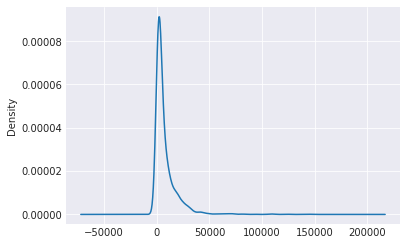

In [57]:
#Visualizing the distribution of the favourite_counts

twitter_archive_master.favorite_count.plot(kind = 'density')

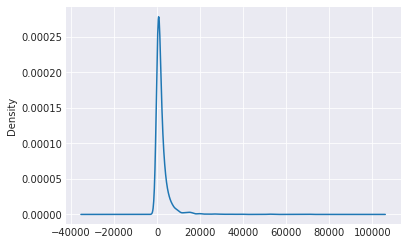

In [58]:
#Visualizing the distribution of the retweet_counts
twitter_archive_master.retweet_count.plot(kind = 'density')

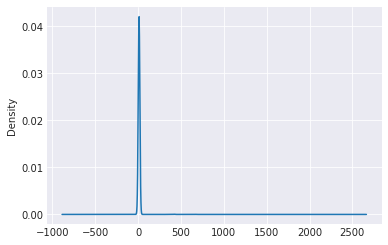

In [59]:
#Visualizing the distribution of the rating_numerator
twitter_archive_master.rating_numerator.plot(kind = 'density')

Text(0,0.5,'No of Retweet')

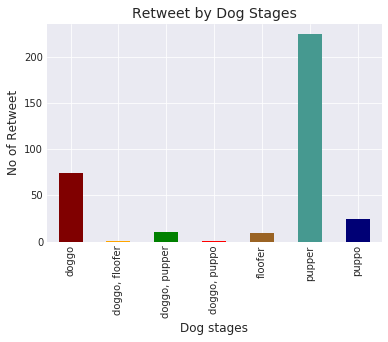

In [61]:
#Visualizing retweet by dog stages 
twitter_archive_master.groupby('stage')['retweet_count'].count().plot(kind = 'bar', color = ['#800000','orange','green','red','#9A6324', '#469990', '#000075'])
plt.title('Retweet by Dog Stages', fontsize = 14)
plt.xlabel('Dog stages', fontsize = 12)
plt.ylabel('No of Retweet', fontsize = 12)

Text(0,0.5,'No of likes')

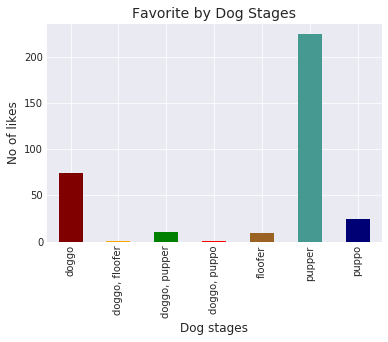

In [68]:
#Visualizing retweet by dog stages 
twitter_archive_master.groupby('stage')['favorite_count'].count().plot(kind = 'bar', color = ['#800000','orange','green','red','#9A6324', '#469990', '#000075'])
plt.title('Favorite by Dog Stages', fontsize = 14)
plt.xlabel('Dog stages', fontsize = 12)
plt.ylabel('No of likes', fontsize = 12)